In [2]:
# Our libs
from networks.transforms import trimap_transform, groupnorm_normalise_image
from networks.models import build_model
from dataloader import PredDataset

# System libs
import os
import argparse

# External libs
import cv2
import numpy as np
import torch


def np_to_torch(x):
    return torch.from_numpy(x).permute(2, 0, 1)[None, :, :, :].float().cuda()


def scale_input(x: np.ndarray, scale: float, scale_type) -> np.ndarray:
    ''' Scales inputs to multiple of 8. '''
    h, w = x.shape[:2]
    h1 = int(np.ceil(scale * h / 8) * 8)
    w1 = int(np.ceil(scale * w / 8) * 8)
    x_scale = cv2.resize(x, (w1, h1), interpolation=scale_type)
    return x_scale


def predict_fba_folder(model, args):
    save_dir = args.output_dir

    dataset_test = PredDataset(args.image_dir, args.trimap_dir)

    gen = iter(dataset_test)
    for item_dict in gen:
        image_np = item_dict['image']
        trimap_np = item_dict['trimap']

        fg, bg, alpha = pred(image_np, trimap_np, model)

        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_fg.png'), fg[:, :, ::-1] * 255)
        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_bg.png'), bg[:, :, ::-1] * 255)
        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_alpha.png'), alpha * 255)


def pred(image_np: np.ndarray, trimap_np: np.ndarray, model) -> np.ndarray:
    ''' Predict alpha, foreground and background.
        Parameters:
        image_np -- the image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        trimap_np -- two channel trimap, first background then foreground. Dimensions: (h, w, 2)
        Returns:
        fg: foreground image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        bg: background image in rgb format between 0 and 1. Dimensions: (h, w, 3)
        alpha: alpha matte image between 0 and 1. Dimensions: (h, w)
    '''
    h, w = trimap_np.shape[:2]

    image_scale_np = scale_input(image_np, 1.0, cv2.INTER_LANCZOS4)
    trimap_scale_np = scale_input(trimap_np, 1.0, cv2.INTER_LANCZOS4)

    with torch.no_grad():

        image_torch = np_to_torch(image_scale_np)
        trimap_torch = np_to_torch(trimap_scale_np)

        trimap_transformed_torch = np_to_torch(trimap_transform(trimap_scale_np))
        image_transformed_torch = groupnorm_normalise_image(image_torch.clone(), format='nchw')

        output = model(image_torch, trimap_torch, image_transformed_torch, trimap_transformed_torch)

        output = cv2.resize(output[0].cpu().numpy().transpose((1, 2, 0)), (w, h), cv2.INTER_LANCZOS4)
    alpha = output[:, :, 0]
    fg = output[:, :, 1:4]
    bg = output[:, :, 4:7]

    alpha[trimap_np[:, :, 0] == 1] = 0
    alpha[trimap_np[:, :, 1] == 1] = 1
    fg[alpha == 1] = image_np[alpha == 1]
    bg[alpha == 0] = image_np[alpha == 0]
    return fg, bg, alpha

In [7]:
class Args:
    def __init__(self):
        self.encoder = 'resnet50_GN_WS'
        self.decoder = 'fba_decoder'
        self.weights = 'FBA.pth'

In [8]:
args = Args()

In [10]:

model = build_model(args)
model.eval();
#     predict_fba_folder(model, args)

modifying input layer to accept 11 channels


In [1]:
from torch.utils.data import Dataset
import numpy as np
import cv2
import os


class PredDataset(Dataset):
    ''' Reads image and trimap pairs from folder.

    '''

    def __init__(self, img_dir, trimap_dir):
        self.img_dir, self.trimap_dir = img_dir, trimap_dir
        self.img_names = [x for x in os.listdir(self.img_dir) if 'png' in x]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]

        image = read_image(os.path.join(self.img_dir, img_name))
        trimap = read_trimap(os.path.join(self.trimap_dir, img_name))
        pred_dict = {'image': image, 'trimap': trimap, 'name': img_name}

        return pred_dict


def read_image(name):
    return (cv2.imread(name) / 255.0)[:, :, ::-1]


def read_trimap(name):
    trimap_im = cv2.imread(name, 0) / 255.0
#     print(trimap_im.shape)
    h, w = trimap_im.shape
    trimap = np.zeros((h, w, 2))
    trimap[trimap_im == 1, 1] = 1
    trimap[trimap_im == 0, 0] = 1
    return trimap


In [3]:
tr = cv2.imread('../../all_people_5.png')

In [5]:
np.unique(tr)

array([  0, 128, 255], dtype=uint8)

In [ ]:
def predict_fba_folder(model,img_name,trimap_name):

    dataset_test = PredDataset(args.image_dir, args.trimap_dir)

    gen = iter(dataset_test)
    for item_dict in gen:
        image_np = item_dict['image']
        trimap_np = item_dict['trimap']

        fg, bg, alpha = pred(image_np, trimap_np, model)

        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_fg.png'), fg[:, :, ::-1] * 255)
        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_bg.png'), bg[:, :, ::-1] * 255)
        cv2.imwrite(os.path.join(save_dir, item_dict['name'][:-4] + '_alpha.png'), alpha * 255)


In [29]:
def pred_new(model,img_name,trimap_name):
    trimap = read_trimap(trimap_name)
    image = (cv2.imread(img_name)/255.0)[:,:,::-1]
    return(pred(image,trimap,model))

In [124]:
fg,bg,alpha = pred_new(model,'../../human.jpg','../../all_people_5.png')

In [125]:
fg.shape

(334, 500, 3)

In [126]:
bg.shape

(334, 500, 3)

In [127]:
alpha.shape

(334, 500)

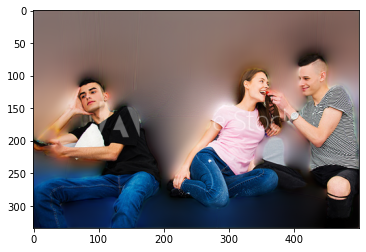

In [128]:
plt.imshow(fg)

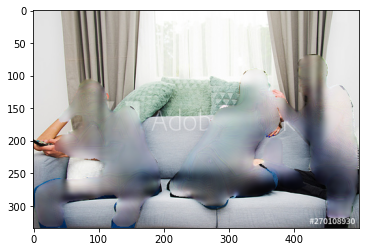

In [129]:
plt.imshow(bg)

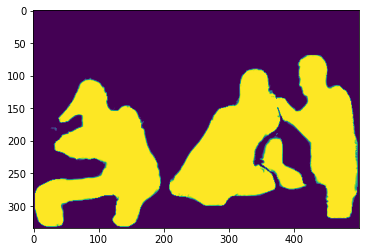

In [130]:
plt.imshow(alpha)

In [40]:
new_bg = cv2.resize(cv2.imread('../../Deep-Image-Matting/pexels-photo-255379.jpeg'),(alpha.shape[1],alpha.shape[0]))

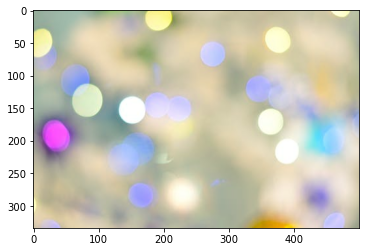

In [48]:
plt.imshow(new_bg)

In [131]:
out = ((alpha[...,None]*fg)*255).astype(int) + ((1-alpha)[...,None]*new_bg).astype(int)

In [132]:
out.shape

(334, 500, 3)

## Only Erosion

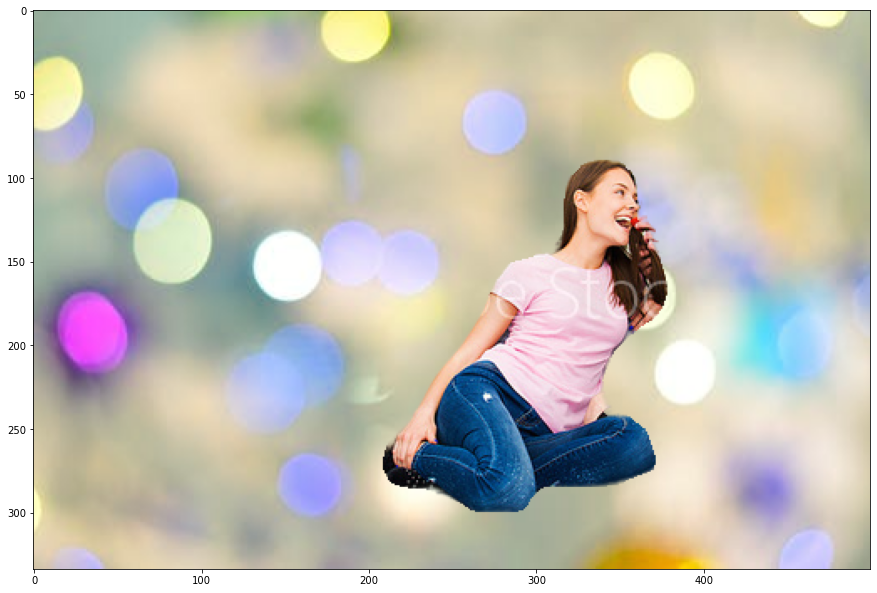

In [105]:
plt.figure(figsize=(15,15))
plt.imshow(out)

## 5 X 5

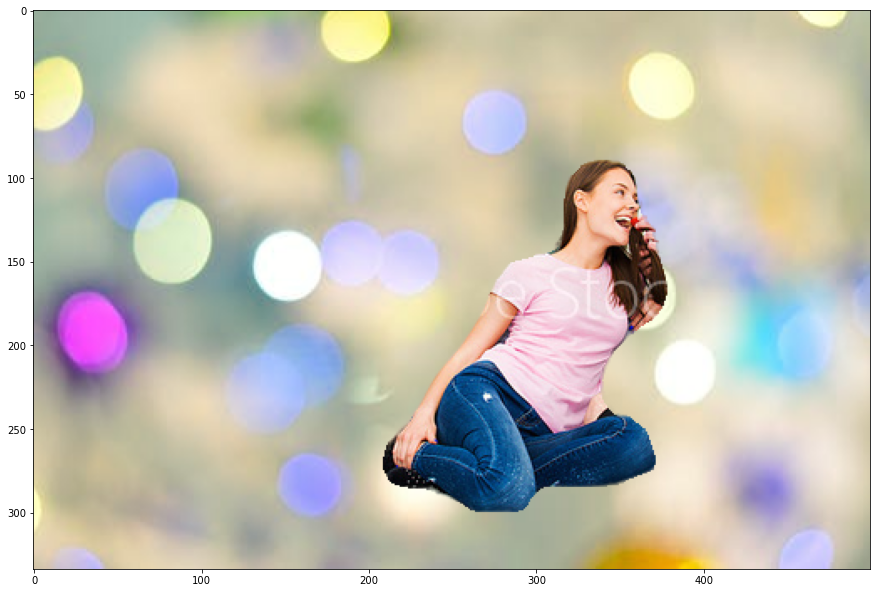

In [114]:
plt.figure(figsize=(15,15))
plt.imshow(out)


## 10 X 10

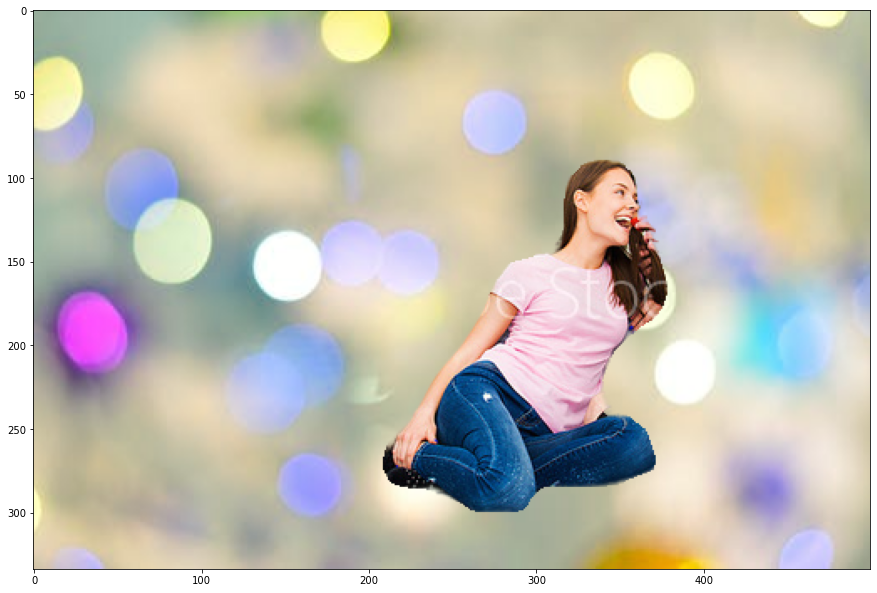

In [123]:
plt.figure(figsize=(15,15))
plt.imshow(out)

## Multiple People

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(out)

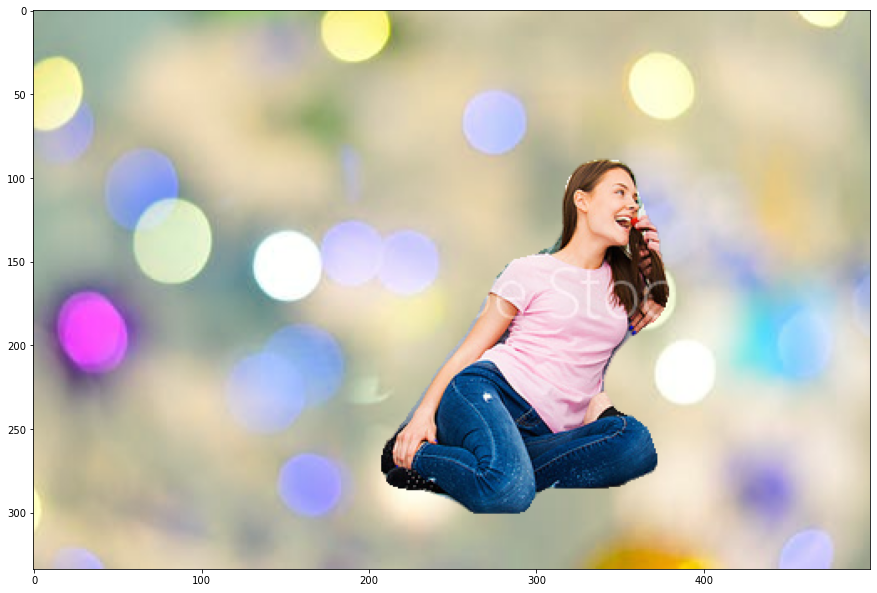

In [88]:
plt.figure(figsize=(15,15))
plt.imshow(out)

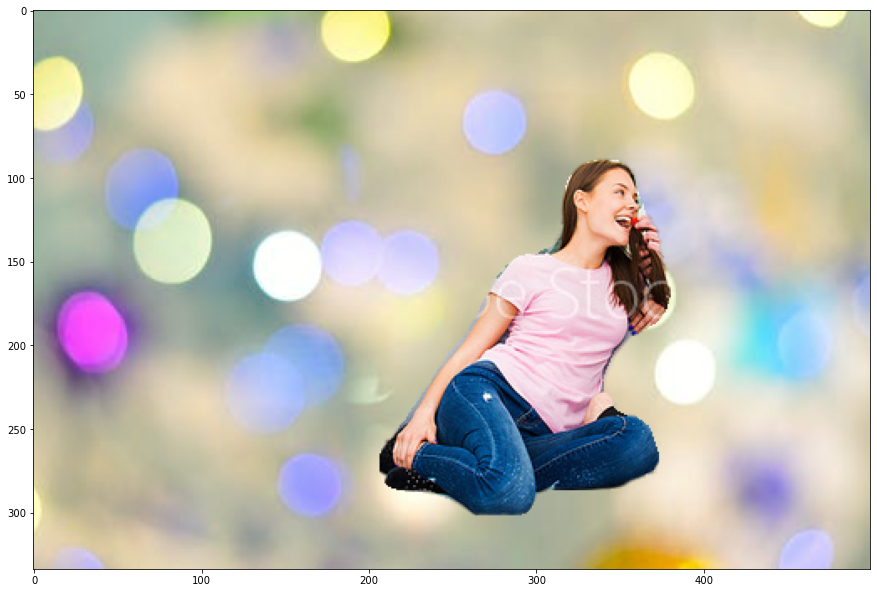

In [97]:
plt.figure(figsize=(15,15))
plt.imshow(out)

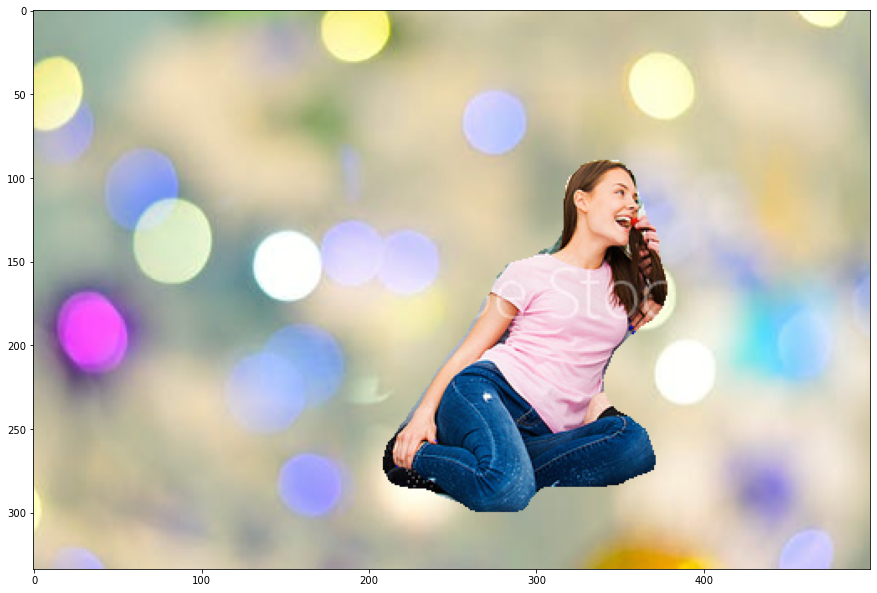

In [80]:
plt.figure(figsize=(15,15))
plt.imshow(out)

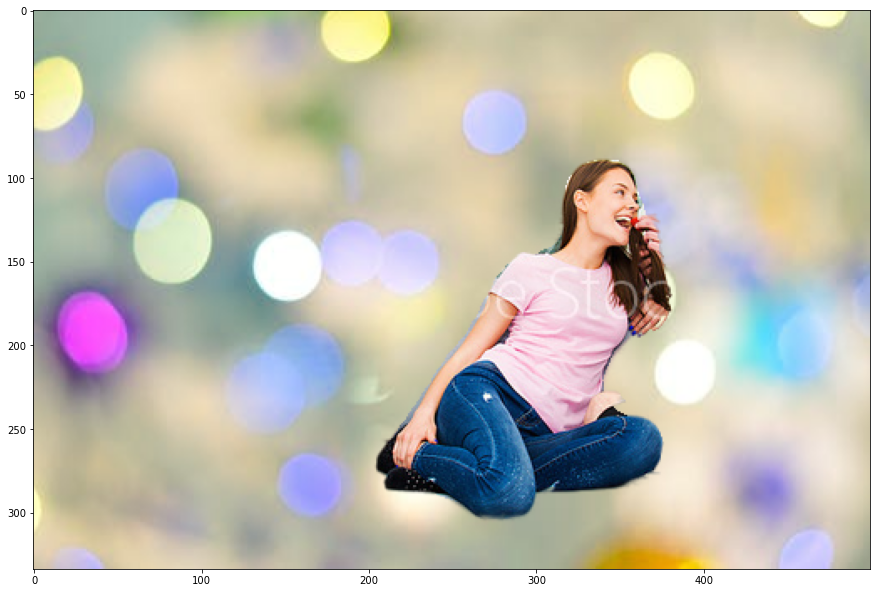

In [72]:
plt.figure(figsize=(15,15))
plt.imshow(out)

In [27]:
tri = read_trimap('../../person.png')

In [17]:
import matplotlib.pyplot as plt

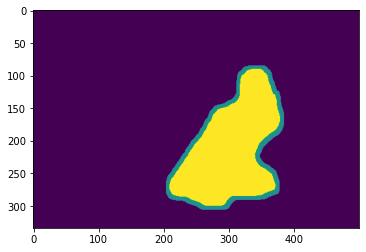

In [18]:
plt.imshow(trimap)

In [19]:
trimap.shape

(334, 500)

In [136]:
import requests
import pickle

In [135]:
arr = np.zeros((50,50))

In [155]:
arr2 = np.zeros((50,50,3))

In [137]:
out = pickle.dumps(arr)

In [159]:
ut = requests.post('http://127.0.0.1:5000/',json = {'trimap':arr.tolist(),'image':arr2.tolist()})

In [163]:
alpha = ut.json()['alpha']

In [164]:
np.array(alpha).shape

(50, 50)